# Transfer learning / Deep Learning

Aplicação do método de Transfer Learning em uma rede de Deep Learning na linguagem Python no ambiente COLAB.

Este desafio consiste em usar uma rede neural pré treinanda em um problema de identificação de cães e gatos. A rede foi otimizada em uma pequena parcela dos dados conhecidos (imagens de gatos e cachorros).

Esse processo consiste em pegar uma rede neural existente que já foi previamente treinada com boa performance em um grande banco de dados e usa-lá como base para um novo modelo de rede neural permitindo uma melhora na acurácia do modelo. Essa estratégia tem se tornado popular nos últimos tempos.


## Procedimento

Dataset: **cats_vs_dogs**

Descrição:
Um grande conjunto de imagens de cães e gatos. Existem aproximadamete 1738 imagens corrompidas.


Homepage: https://www.microsoft.com/en-us/download/details.aspx?id=54765

Foi utilizado o classificador de imagens  [VGG16](https://arxiv.org/pdf/1409.1556.pdf) em seu *state-of-the-art* que [ganhou o *ImageNet challenge* em 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), aplicando-o para extrair as características de um pequeno conjunto de imagens e depois usando o modelo refinado para verificar a sua acurácia.

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Obtendo o dataset **kagglecatsanddogs_5340**

A primeira etapa foi baixar o dataset. Foi utilizado o [kagglecatsanddogs_5340](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip), que contém aproximadamete 12500 imagens separadas em duas pastas, que representam as suas categorias (Cachorros e gatos).


Para baixar esse dataset basta executar a célula abaixo.

In [ ]:
# https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!echo "Downloading kagglecatsanddogs_5340 for image notebooks"
!curl -L -o kagglecatsanddogs_5340.zip --progress-bar 'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip'
!unzip -a kagglecatsanddogs_5340.zip
### !tar -xzf kagglecatsanddogs_5340.zip
!rm kagglecatsanddogs_5340.zip
!ls


In [2]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print('Categorias: ',categories)

Categorias:  ['PetImages/Dog', 'PetImages/Cat']


Funções para pré-processamento das imagens, retornando a imagem e seus dados (função get_image()) ou somente os seus dados(função get_image2()).

In [3]:
# helper functions to load image and return it and input vector
def get_image(path):
    img = image.image_utils.load_img(path, target_size=(224, 224)) #acrescentei image_utils.
    x = image.image_utils.img_to_array(img) ##aqui tb
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


def get_image2(path):
    img = image.image_utils.load_img(path, target_size=(224, 224)) #acrescentei image_utils.
    x = image.image_utils.img_to_array(img) ##aqui tb
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

Carregando 1200 imagens de cada pasta.
Esse número foi arbitrário, apenas para reduzir o tempo de processamento do dataset.

In [ ]:
data = []
C_LIMITE = 1200
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    ii =0
    for img_path in images:
      if ii > C_LIMITE:
        continue
      try:
        x = get_image2(img_path)
        data.append({'x':np.array(x[0]), 'y':c})
        ii += 1
        print (ii)
      except:
        print('erro, continuando....')
      

# count the number of classes
num_classes = len(categories)

Randomizando a ordem dos dados

In [5]:
random.shuffle(data)

Criando os conjuntos de trainamento / validação / testes (70%, 15%, 15%)

In [6]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separando os dados e suas etiquetas

In [7]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]


Pre-processamento dos dados, normalizando ente 0 e 1.

In [8]:
# normalizando os dados
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# mudando as etiquetas para vetores one-hot
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(361, 2)


Resumo do que foi feito.

In [9]:
# summary
print("Carregamento de %d imagens em %d categorias"%(len(data), num_classes))
print("Divisão em treino / validação / teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("Tamanho do conjunto de treino: ", x_train.shape)
print("Nº etiquetas do conj. de treino: ", y_train.shape)


Carregamento de 2402 imagens em 2 categorias
Divisão em treino / validação / teste: 1681, 360, 361
Tamanho do conjunto de treino:  (1681, 224, 224, 3)
Nº etiquetas do conj. de treino:  (1681, 2)


Exemplos de imagens do dataset

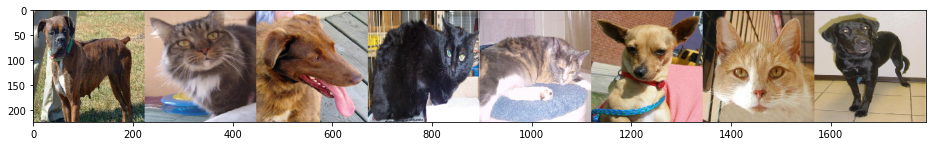

In [10]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.image_utils.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image);

## Transfer learning usando uma rede neural existente

Agora vamos aplicar uma rede pré-treinada (em um grande conjunto de imagens) em nosso pequeno conjunto de imagens .

Vamos iniciar carregando o modelo VGG16 da biblioteca keras, o qual já foi treinado no **ImageNet** e os seus ganhos salvos online. Depois do modelo baixado voce pode inspecionar as camadas com o método `summary()`.

In [11]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Percebemos que a rede neural VGG16 é _muito_ grande. Ela contém 13 camadas convolucionais e 2 camadas finais totalmente conectadas e tem mais de 138 milhões de parametros.

VGG16 foi feito para resolver **ImageNet**, e alcançou [8.8% sendo o top-5 em taxa de erro](https://github.com/jcjohnson/cnn-benchmarks), o que significa que 91.2% das amostras foram corretamente classificadas. 

Para usar essa rede neural temos que remover a camada final de classificação,  que corresponde ao conjunto **ImageNet**, e substituí-al com uma camada *softmax* para o nosso conjunto de dados.

In [12]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Agora vamos retreinar essa rede neural, `model_new` com o novo conjunto de imagens e etiquetas. Primeiramente, precisamos congelar os pesos e bias de todas as camadas da rede, exceto a nossa nova no final. 

Ajustando a propriedade `trainable` em cada camada com o valor *false* (exceto a nossa camada de classificação), nós garantimos que essas camadas não serão re-treinadas.

In [13]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Treinando o novo modelo com os seus hyperparâmetros

In [14]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))


Epoch 1/10
14/14 [==============================] - 35s 2s/step - loss: 0.8463 - accuracy: 0.5461 - val_loss: 0.6216 - val_accuracy: 0.6222
Epoch 2/10
14/14 [==============================] - 10s 738ms/step - loss: 0.5459 - accuracy: 0.7026 - val_loss: 0.4747 - val_accuracy: 0.7694
Epoch 3/10
14/14 [==============================] - 10s 754ms/step - loss: 0.4295 - accuracy: 0.8108 - val_loss: 0.3411 - val_accuracy: 0.8833
Epoch 4/10
14/14 [==============================] - 11s 776ms/step - loss: 0.3765 - accuracy: 0.8554 - val_loss: 0.3113 - val_accuracy: 0.8917
Epoch 5/10
14/14 [==============================] - 11s 795ms/step - loss: 0.3473 - accuracy: 0.8697 - val_loss: 0.3014 - val_accuracy: 0.8889
Epoch 6/10
14/14 [==============================] - 11s 816ms/step - loss: 0.3237 - accuracy: 0.8804 - val_loss: 0.3015 - val_accuracy: 0.8722
Epoch 7/10
14/14 [==============================] - 12s 846ms/step - loss: 0.3045 - accuracy: 0.8899 - val_loss: 0.2641 - val_accuracy: 0.9167
Ep

Evolução do modelo ao longo das gerações

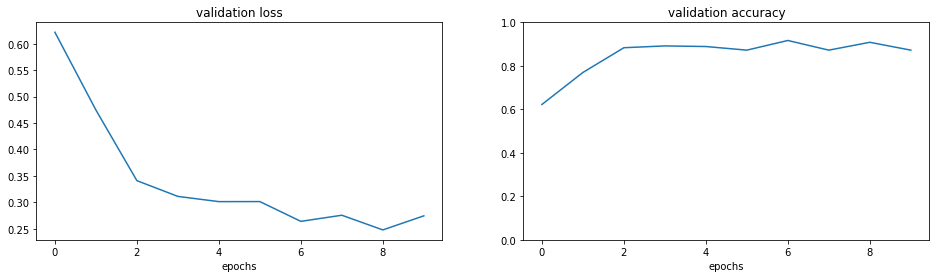

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("Gerações")
ax2.set_ylim(0, 1)

plt.show()

In [31]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Perdas no conjunto de testes:', loss)
print('Acurácia no conjunto de testes:', accuracy)

Perdas no conjunto de testes: 0.3831794261932373
Acurácia no conjunto de testes: 0.8559556603431702


Para testar a predição basta rodar essa célula.

1/1 [==============================] - 0s 17ms/step
Model result:  PetImages/Cat 
The correct answer is PetImages/Cat


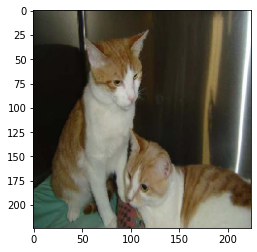

In [32]:
img, x = get_image('./PetImages/Cat/'+str(random.randint(1,10000))+'.jpg');
plt.imshow(img);
probabilities = model_new.predict([x]);
print('Model result: ', categories[probabilities.argmax()], '\nThe correct answer is PetImages/Cat')